In [1]:
import ROOT
from ROOT import TMVA

import numpy as np

Welcome to JupyROOT 6.15/01


In [2]:
inputFile = ROOT.TFile("Higgs_data.root")
inputFile.ls()

TFile**		Higgs_data.root	
 TFile*		Higgs_data.root	
  KEY: TTree	sig_tree;1	tree
  KEY: TTree	bkg_tree;1	tree


In [3]:
sig_evts = inputFile.sig_tree.AsMatrix(['m_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb'])

In [4]:
print(sig_evts)

[[1.35376    0.97956312 0.97807616 ... 0.72165745 0.98875093 0.87667835]
 [0.3022199  0.83304816 0.98569965 ... 0.77973217 0.99235576 0.79834259]
 [0.90975326 1.10833049 0.9856922  ... 0.8032515  0.86592442 0.78011757]
 ...
 [0.78733569 0.97868377 0.98237854 ... 0.96853018 0.93126822 0.91213906]
 [0.92211759 1.03808665 0.98750263 ... 0.46553683 0.80048835 0.80058527]
 [0.7312851  1.06170535 1.07203448 ... 0.87044066 1.11418879 0.96912521]]


In [5]:
bkg_evts = inputFile.bkg_tree.AsMatrix(['m_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb'])

In [6]:
print(bkg_evts)

[[0.94665247 1.02870369 0.99865609 ... 0.86920023 1.0267365  0.95790398]
 [0.82376057 0.93819141 0.97175819 ... 0.43055329 0.96135694 0.95781791]
 [0.94453603 1.02626061 0.98219675 ... 1.25097895 0.83004463 0.76130795]
 ...
 [0.77256989 1.01168537 0.98482263 ... 1.05128407 0.86403567 0.76281738]
 [0.82492363 0.91738319 0.99552536 ... 3.95504141 2.08921599 1.56324244]
 [2.45921826 1.29498148 0.98175466 ... 0.51517493 0.95003647 0.92472702]]


### Make Input data and target arrays
Make array of target values. Traget = 1 for signal events and = 0 for background ones

In [7]:
sig_target = np.arange(len(sig_evts), dtype='float')
sig_target[0:len(sig_target)]=1.
bkg_target = np.arange(len(bkg_evts), dtype='float')
bkg_target[0:len(bkg_target)]=0.

In [8]:
## Use numpy function concatenate to append signal and backgorund arrays
inputs = np.concatenate((sig_evts,bkg_evts))
targets = np.concatenate((sig_target,bkg_target))

#### Inspect  input distributions

We look for example at some input distributions

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


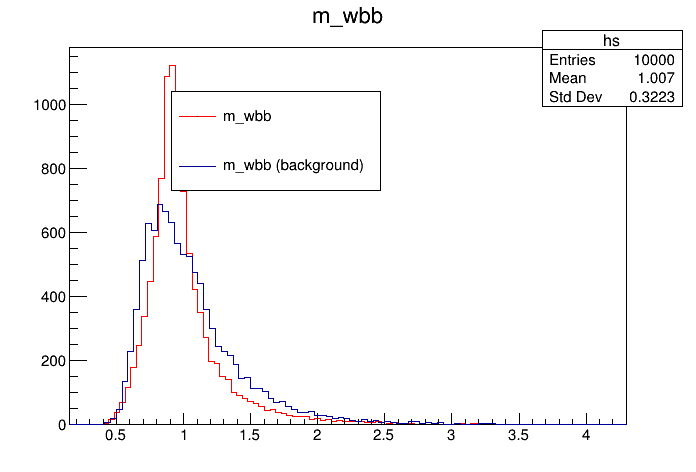

In [9]:
## we make an histogram of variable m_wbb (ivar=5)
ivar = 5
varName = "m_wbb"
h1 = ROOT.TH1D("hs",varName,100,1,0)
h2 = ROOT.TH1D("hb",varName + " (background)",100,1,0)
dims = inputs.shape
nevt = dims[0]
for i in range(0,nevt):
    if (targets[i] == 1.):
        h1.Fill(inputs[i,ivar])
    else:
        h2.Fill(inputs[i,ivar])
        
        
h1.SetLineColor(ROOT.kRed)
h1.Draw()
h2.Draw("SAME")
ROOT.gPad.BuildLegend()
ROOT.gPad.Draw()

### Run Keras 

In [10]:
import numpy as np
np.random.seed(1234)
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import subprocess
import h5py
import pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


####  Use scikit-learn function to split data in test and training set

In [11]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
        inputs, targets, test_size=0.10, random_state=123)

In [12]:
print(targets_train)

[1. 1. 0. ... 0. 0. 0.]


#### Define the Keras model

In [44]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh', input_dim=7))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))


# Store model to file
##model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Set loss and optimizer
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

#### Train the Keras model

#### Apply input variable transformations using scikit-learn

We could transform input variable using some transformation from scikit-learn. 
For example we could use StandardScaler transformation from scikit.
This transforms variable to be of mean zero and standard deviation=1

Example code: (not used so far)

```
from sklearn.preprocessing import StandardScaler
preprocessing_input = StandardScaler()
preprocessing_input.fit(inputs_train)
trans_inputs_train =  preprocessing_input.transform(inputs_train)
```

In [15]:
model.fit(inputs_train,targets_train,batch_size=100,epochs=20,validation_split=0.30)
#model.fit(trans_inputs_train,targets,batch_size=100,epochs=10,validation_split=0.30)

Train on 12600 samples, validate on 5400 samples
Epoch 1/20
12600/12600 [==============================] - 0s 35us/step - loss: 0.6797 - acc: 0.5541 - val_loss: 0.6692 - val_acc: 0.5469
Epoch 2/20
12600/12600 [==============================] - 0s 16us/step - loss: 0.6612 - acc: 0.6002 - val_loss: 0.6517 - val_acc: 0.6180
Epoch 3/20
12600/12600 [==============================] - 0s 17us/step - loss: 0.6459 - acc: 0.6275 - val_loss: 0.6478 - val_acc: 0.6220
Epoch 4/20
12600/12600 [==============================] - 0s 16us/step - loss: 0.6376 - acc: 0.6372 - val_loss: 0.6371 - val_acc: 0.6406
Epoch 5/20
12600/12600 [==============================] - 0s 16us/step - loss: 0.6318 - acc: 0.6470 - val_loss: 0.6308 - val_acc: 0.6478
Epoch 6/20
12600/12600 [==============================] - 0s 16us/step - loss: 0.6285 - acc: 0.6479 - val_loss: 0.6268 - val_acc: 0.6469
Epoch 7/20
12600/12600 [==============================] - 0s 16us/step - loss: 0.6247 - acc: 0.6550 - val_loss: 0.6252 - val_acc:

2018-09-19 16:57:26.243532: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


#### Perform prediction with trained model using test set

In [16]:
keras_out = model.predict(inputs_test)
print(keras_out)

[[0.47148266]
 [0.25130108]
 [0.55454135]
 ...
 [0.6441037 ]
 [0.37903833]
 [0.30268615]]


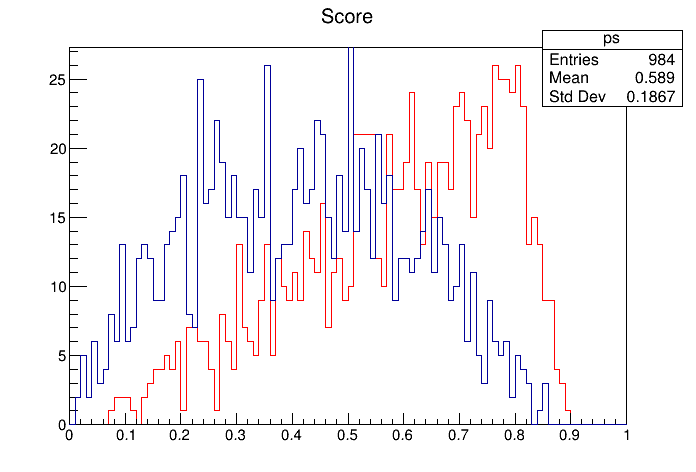

In [17]:
pS = ROOT.TH1D("ps","Score",100,0,1)
pB = ROOT.TH1D("pb","Score (Background)",100,0,1)
for i in range (0,keras_out.shape[0]):
    if (targets_test[i] == 1): 
        pS.Fill(keras_out[i,0])
    else:
        pB.Fill(keras_out[i,0])
        
pS.SetLineColor(ROOT.kRed)
pS.Draw()
pB.Draw('same')
ROOT.gPad.Draw()

#### Compute ROC 

In [18]:
from sklearn import metrics

##y_true = np.hstack((np.ones(quarks.GetEntries()), np.zeros(gluons.GetEntries())))
##y_score = np.hstack((mvaValues_quarks, mvaValues_gluons))
fpr, tpr, thresholds = metrics.roc_curve(targets_test, keras_out)

# Get AUC from ROC
auc = metrics.auc(fpr, tpr)
print('AUC: {}'.format(auc))

AUC: 0.737733859868


#### Save trained model in a file

In [25]:
#model.save('trained_model_dense.h5')

In [26]:
print(inputs_train)

[[1.01573563 0.89369214 1.11820185 ... 0.16855672 0.58038819 0.65353173]
 [0.95382494 1.230353   0.99021089 ... 0.81501591 1.10848105 0.93145901]
 [0.77363604 0.87485951 0.99559164 ... 0.59691745 0.83990759 1.19088554]
 ...
 [0.80430341 0.84451807 0.98065901 ... 0.8309204  0.90684873 0.75724876]
 [0.70365548 0.87700212 1.23832238 ... 5.19530678 2.71979046 2.0217638 ]
 [0.91426659 0.95217115 0.98160356 ... 1.3336854  1.31489611 1.27817643]]


### Use Decision Trees from scikit-learn

We create a GradientBoostingClassifier. 
Look at the scikit documentation for all the possible options

In [51]:
from sklearn import tree
from sklearn import ensemble

In [52]:
gtb = ensemble.GradientBoostingClassifier()

In [53]:
gtb = gtb.fit(inputs_train, targets_train)

In [71]:
gtb_out = gtb.predict_proba(inputs_test)

In [72]:
print(gtb_out)
out = gtb_out[:,1]
print(out)

[[0.63320792 0.36679208]
 [0.82717954 0.17282046]
 [0.40019724 0.59980276]
 ...
 [0.32821198 0.67178802]
 [0.3480982  0.6519018 ]
 [0.54532526 0.45467474]]
[0.36679208 0.17282046 0.59980276 ... 0.67178802 0.6519018  0.45467474]


Warning in <TFile::Append>: Replacing existing TH1: score_sig (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: score_bkg (Potential memory leak).


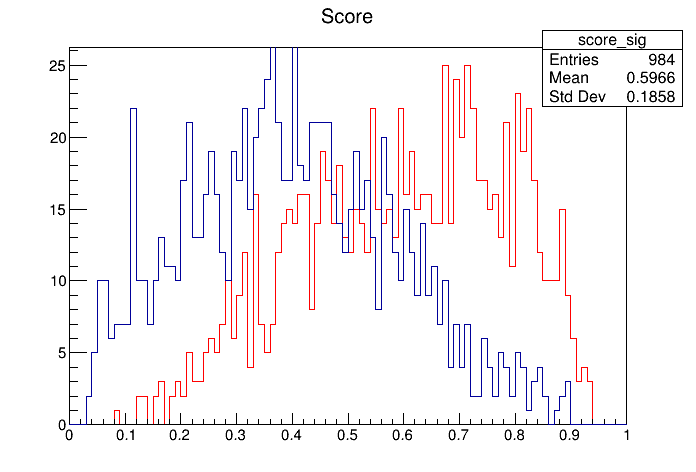

In [73]:
pS = ROOT.TH1D("score_sig","Score",100,0,1)
pB = ROOT.TH1D("score_bkg","Score (Background)",100,0,1)
for i in range (0,out.shape[0]):
    if (targets_test[i] == 1): 
        pS.Fill(out[i])
    else:
        pB.Fill(out[i])
        
pS.SetLineColor(ROOT.kRed)
pS.Draw()
pB.Draw('same')
ROOT.gPad.Draw()

In [75]:
nevt = out.shape[0]
print nevt
ns=0
nb=0
vscores = ROOT.std.vector('float')(nevt)
vtargets = ROOT.std.vector('bool')(nevt)
for ievt in range(0,nevt): 
    #need to use second column
    vscores[ievt] = out[ievt]
    vtargets[ievt] = int(targets_test[ievt])
 
        
##print vtargets
roc = ROOT.TMVA.ROCCurve(vscores,vtargets) 
print ' ROC Integral (AUC) = ',roc.GetROCIntegral()
graph = roc.GetROCCurve()


2000
 ROC Integral (AUC) =  0.767051865278


In [76]:
c3 = ROOT.TCanvas()
graph.Draw('AL')
c3.SaveAs('graph.pdf')

Info in <TCanvas::Print>: pdf file graph.pdf has been created


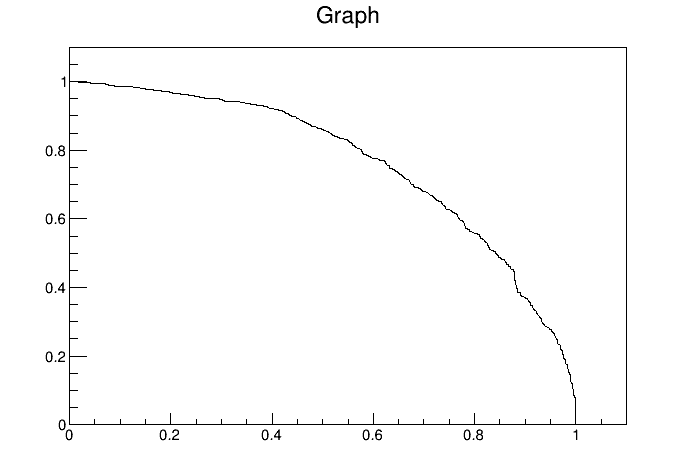

In [77]:
c3.Draw()

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(targets_test, out)

# Get AUC from ROC
auc = metrics.auc(fpr, tpr)
print('AUC: {}'.format(auc))

AUC: 0.766856315217
